# 1- Setup Project

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# %cd /content/drive/MyDrive/ATD-WSD

# # Create dir to for storing trained model
# #!mkdir Baseline-w2v

In [3]:
# !pip install numpy==1.23.1
# !pip install tensorflow==2.14.0

In [4]:
import re
import pickle
import json
import numpy as np
import time
import random
import joblib

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.models import Model
from tensorflow.keras.layers import Input
from keras.layers import Embedding, Dense, Dropout, LSTM, Bidirectional, TimeDistributed, InputLayer
from tensorflow.keras.models import Sequential
from keras.optimizers import Adam
from keras.utils import Sequence
from keras.initializers import glorot_normal
from keras.callbacks import ModelCheckpoint
from rich import print_json

In [5]:
if tf.config.list_physical_devices('GPU'):
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("GPU device not found: working on CPU")

Default GPU Device: /device:GPU:0


# 2- Importing Dataset
The dataset that was prepared using Gemini which is 20% of the train, 100% val and testing taken from [original dataset](https://github.com/AliOsm/arabic-text-diacritization/tree/master/dataset)
```
[{
    "sentence": "some text in arabic",
    "words": [
      {
        "word": "word_1",
        "word_sense": "definition_1"
        "pos" : "part_of_speech_1"
      }
    ]
}]
```


In [6]:
# Helpers
def read_json(file_path):
  with open(file_path, mode="r", encoding="utf-8") as json_data:
    return json.load(json_data)

def get_sentences(data):
  sentences = []
  for s in data:
    sentences.append(s['sentence'])
  return sentences

def pprint(json_data):
  print_json(data=json_data, highlight=False)

In [7]:
train_data = read_json("../Dataset/10485_train_wsd.json")
val_data = read_json("../Dataset/2517_val_wsd.json")
# train_data = train_data[:-6485]
# val_data = val_data[:-2100]
print('Training data length:', len(train_data))
print("Train Sample")
pprint(train_data[100])

print('Validation data length:', len(val_data))
print("Val Sample")
pprint(val_data[1])

Training data length: 10485
Train Sample


{
  "sentence": "فَاسِدٌ",
  "words": [
    {
      "pos": "adjective",
      "sense": "corrupt",
      "word": "فَاسِدٌ"
    }
  ]
}

Validation data length: 2517
Val Sample


{
  "sentence": "وَلَوْ لَمْ تَزِدْ( 26 / 106 )",
  "words": [
    {
      "word": "وَلَوْ",
      "pos": "conjunction",
      "sense": "even if"
    },
    {
      "word": "لَمْ",
      "pos": "negative particle",
      "sense": "not"
    },
    {
      "word": "تَزِدْ",
      "pos": "verb",
      "sense": "to increase"
    }
  ]
}

# 3- Constants

In [8]:
# Helpers
def CHAR_IDX(LIST):
    char2idx = {}
    idx2char = {}

    for i, char in enumerate(LIST):
        char2idx[char] = i
        idx2char[i] = char

    return char2idx, idx2char

In [9]:
DIC = {"sentence": "", "words": ""}  
ARABIC_CHAR = "ىعظحرسيشضقثلصطكآماإهزءأفؤغجئدةخوبذتن"
NUMBERS = "0123456789٠١٢٣٤٥٦٧٨٩"

# 15 possible Diacritics
FATHATAN = u'\u064b'
DAMMATAN = u'\u064c'
KASRATAN = u'\u064d'
FATHA = u'\u064e'
DAMMA = u'\u064f'
KASRA = u'\u0650'
SHADDA = u'\u0651'
SUKUN = u'\u0652'

DIACRITICS = [
    "",              # No Diacritic
    FATHA,           # Fatha
    FATHATAN,        # Fathatah
    DAMMA,           # Damma
    DAMMATAN,        # Dammatan
    KASRA,           # Kasra
    KASRATAN,        # Kasratan
    SUKUN,           # Sukun
    SHADDA,          # Shadda
    SHADDA+FATHA,    # Shadda + Fatha
    SHADDA+FATHATAN, # Shadda + Fathatah
    SHADDA+DAMMA,    # Shadda + Damma
    SHADDA+DAMMATAN, # Shadda + Dammatan
    SHADDA+KASRA,    # Shadda + Kasra
    SHADDA+KASRATAN  # Shadda + Kasratan
]

PUNCTUATIONS = [
    ".",    "،",    ":",    "؛",
    "-",    "–",    "«",    "»",
    "~",    "؟",    "!",    "*",
    "(",    ")",    "[",    "]",
    "{",    "}",    ";",    "\n",
    "'",    "\"",   "`",    "/",
    ",",    "?",    '’',    '“',
    '…',    '﴾',    '﴿',    "+",
    "*",    "=",    "&",    "_",
    "\n",   "\u200d",       "\u200f"
]


# Special Tokens
UNK_TOKEN = "u"
PAD_TOKEN = "p"
SOS_TOKEN = "s"
EOS_TOKEN = "e"
SPECIAL_TOKENS = [PAD_TOKEN, SOS_TOKEN, EOS_TOKEN, UNK_TOKEN]

# Combine
ARABIC_CHAR_SPACE = list(ARABIC_CHAR) + [' ']
ARABIC_CHAR_VALID = ARABIC_CHAR_SPACE + DIACRITICS
ALLCHARS = ARABIC_CHAR_SPACE + list(NUMBERS) + PUNCTUATIONS + SPECIAL_TOKENS
CLASSES = DIACRITICS + SPECIAL_TOKENS

In [10]:
char_mapping, reverse_char_mapping = CHAR_IDX(ALLCHARS)
class_mapping, reverse_class_mapping = CHAR_IDX(CLASSES)

print("Char Mapping Size:", len(char_mapping))
print("Class Mapping Size:", len(class_mapping))

Char Mapping Size: 98
Class Mapping Size: 19


# 4- Helper Functions

In [11]:
def remove_diacritics_line(data):
    return data.translate(str.maketrans('', '', ''.join(DIACRITICS)))

def get_max_size(data):
  return max(len(remove_diacritics_line(item['sentence'].strip())) for item in data)

def get_min_size(data):
  return min(len(remove_diacritics_line(item['sentence'].strip())) for item in data)

def one_hot_matrix(data, size):
    one_hot_matrix = [[1 if j == i else 0 for j in range(size)] for i in data]
    return one_hot_matrix

def one_hot_vector(index , size):
    one_hot_vector = [1 if j == index else 0 for j in range(size)]
    return one_hot_vector

# def get_words(l, line):
#   last_word = ""
#   first_word = ""
#   list_of_words = []

#   for i, w in enumerate(l.split()):
#     if i == 0:
#       first_word = w
#     if w not in PUNCTUATIONS:
#       last_word = w
#   found_first = False
#   if "words" not in line:
#     return {"sentence": l, "words": []}
#   for j, w in enumerate(line['words']):
#     if "word" not in w:
#       continue
#     if w['word'] == first_word:
#       found_first = True

#     if found_first:
#       list_of_words.append(w)
#       if w['word'] == last_word:
#         dic = {"sentence": l, "words": list_of_words}
#         return dic
#   dic = {"sentence": l, "words": list_of_words}
#   return dic

# def split_at(line, at='\n'):
#   new_data = []
#   for l in line['sentence'].split(at):
#     new_data.append(get_words(l, line))
#   return new_data

def punc_split(data):
  new_data = []
  for line in data:
    line['sentence'] = line['sentence'].replace('.', '.\n')
    line['sentence'] = line['sentence'].replace(',', ',\n')
    line['sentence'] = line['sentence'].replace('،', '،\n')
    line['sentence'] = line['sentence'].replace(':', ':\n')
    line['sentence'] = line['sentence'].replace(';', ';\n')
    line['sentence'] = line['sentence'].replace('؛', '؛\n')
    line['sentence'] = line['sentence'].replace('(', '\n(')
    line['sentence'] = line['sentence'].replace(')', ')\n')
    line['sentence'] = line['sentence'].replace('[', '\n[')
    line['sentence'] = line['sentence'].replace(']', ']\n')
    line['sentence'] = line['sentence'].replace('{', '\n{')
    line['sentence'] = line['sentence'].replace('}', '}\n')
    line['sentence'] = line['sentence'].replace('«', '\n«')
    line['sentence'] = line['sentence'].replace('»', '»\n')
    line['sentence'] = line['sentence'].replace('؟', '؟\n')
    line['sentence'] = line['sentence'].replace('?', '?\n')
    line['sentence'] = line['sentence'].replace('!', '!\n')
    line['sentence'] = line['sentence'].replace('-', '-\n')

     
    # new_data.append(dic)  
    for l in line['sentence'].split('\n'):
      words = []
      if 'words' in line:
          words = line['words']
      new_data.append({"sentence": l, "words": words} )   
      # a = get_words(l, line)
      # if a and len(a) > 0:
      # new_data.append(a)
        
  return new_data

def split_on_length(sentence_data, max_len=500):
    split_sentences = []

    for sentence in punc_split(sentence_data):
       new_sentence = remove_diacritics_line(sentence['sentence']).strip()
       
       if len(new_sentence) != 0:
          if len(new_sentence) > 0 and len(new_sentence) <= max_len:
                  #sentence['sentence'] = sentence['sentence'].strip()
                  #split_sentences.append(sentence)
                  # dic = 
                  split_sentences.append({"sentence": sentence['sentence'].strip(), "words": sentence['words']})
          else:
            sentence_words = sentence['sentence'].split()
            temp_sentence = ''

            for word in sentence_words:
              if len(remove_diacritics_line(temp_sentence).strip()) + len(remove_diacritics_line(word).strip()) + 1 > max_len:
                  if len(remove_diacritics_line(temp_sentence).strip()) > 0:
                      # dic = {"sentence": temp_sentence.strip(), "words": sentence['words']}
                      split_sentences.append({"sentence": temp_sentence.strip(), "words": sentence['words']})
                      # a = re.sub(temp_sentence, f'{temp_sentence}\\n', sentence['sentence'])
                      # dic = {"sentence": a.strip(), "words": sentence['words']}
                      # n = split_at(dic)
                      # for i in n:
                      #   if len(i['sentence']) <= max_len:
                      #     i['sentence'] = i['sentence'].strip()
                      #     split_sentences.append(i)
                  temp_sentence = word
              else:
                  temp_sentence = word if temp_sentence == '' else temp_sentence + ' ' + word

            if len(remove_diacritics_line(temp_sentence).strip()) > 0:
                  # dic = {"sentence": temp_sentence.strip(), "words": sentence['words']}
                  split_sentences.append({"sentence": temp_sentence.strip(), "words": sentence['words']})
                  # a = re.sub(temp_sentence, f'{temp_sentence}\\n', sentence['sentence'])
                  # dic = {"sentence": a.strip(), "words": sentence['words']}

                  # #sentence['sentence'] = re.sub(temp_sentence, f'{temp_sentence}\\n', sentence['sentence'])
                  # n = split_at(dic)
                  # for i in n:
                  #   if len(i['sentence']) <= max_len:
                  #     i['sentence'] = i['sentence'].strip()
                  #     split_sentences.append(i)

    return split_sentences
def get_all_senses(docs):
    sense = []
    for doc in docs:
      for word in doc['words']:
        if 'sense' in word:
          sense.append(word['sense'])
    return sense

def train_word_embeddings(docs):
    # doc = get_sentences(docs)
    doc = get_all_senses(docs)
    
    
    # doc.extend(words)
    tokenizer = Tokenizer(oov_token='<OOV>')
    tokenizer.fit_on_texts(doc)

    sentences = [dc.split() for dc in doc ]
    sentences.append([UNK_TOKEN])
   
    # sentences.append([DIAC_TOKEN])
    print(len(sentences))
    word2vec_model = Word2Vec(sentences, vector_size = 300, window=5, min_count=1, workers=4)

    word_embeddings = word2vec_model.wv

    return word_embeddings, tokenizer

def get_word_embeddings(word):
    encoded_docs = tokenizer.texts_to_sequences(word)
    word_embeddings_for_sample = []
    for word_index in encoded_docs:
      if len(word_index) > 0:
        if word_index[0] in data_embeddings:
          word_embeddings_for_sample.append(data_embeddings[word_index[0]])
    return word_embeddings_for_sample

# 5- Prepare Data

In [12]:
split_length_train_data      = split_on_length(train_data)
split_length_val_data      = split_on_length(val_data)

print("Train Data Size:", len(split_length_train_data))
print('Training data max:', get_max_size(split_length_train_data))
print('Training data min:', get_min_size(split_length_train_data))
# print("Train Sample:", split_length_train_data[0:1])
print()

print("Val Data Size:", len(split_length_val_data))
print('Validation data max:', get_max_size(split_length_val_data))
print('Validation data min:', get_min_size(split_length_val_data))
# print("Val Sample:", split_length_val_data[0:2])

Train Data Size: 35722
Training data max: 500
Training data min: 1

Val Data Size: 15120
Validation data max: 500
Validation data min: 1


#### Data without diacritics and without punc and numbers

In [13]:
def clean_data(data, remove_dia=False):
  cleaned_data = []
  for text in data:
    temp = {'sentence': "", 'words':[]}
    sen = text['sentence']
    cleaned = ''.join(char for char in sen if char in ARABIC_CHAR_VALID)
    cleaned = cleaned.strip()
    if cleaned != "":
      if remove_dia:
        cleaned = remove_diacritics_line(cleaned)

      temp['sentence'] = cleaned
      temp['words'] = text['words']
      cleaned_data.append(temp)
  return cleaned_data


clean_diac_train_data = clean_data(split_length_train_data)
clean_diac_val_data = clean_data(split_length_val_data)

print('Training data length:', len(clean_diac_train_data))
print('Validation data length:', len(clean_diac_val_data))

# pprint(clean_diac_train_data[0:2])

Training data length: 31578
Validation data length: 13458


#### Data with diacritics and without punc and numbers

In [14]:
clean_train_data = clean_data(split_length_train_data, remove_dia=True)
clean_val_data = clean_data(split_length_val_data, remove_dia=True)

print('Training data length:', len(clean_train_data))
print('Validation data length:', len(clean_val_data))

pprint(clean_train_data[0:2])

Training data length: 31578
Validation data length: 13458


[
  {
    "sentence": "ولو جمع ثم علم ترك ركن من الأولى بطلتا ويعيدهما جامعا",
    "words": [
      {
        "pos": "conjunction",
        "sense": "even if",
        "word": "وَلَوْ"
      },
      {
        "pos": "verb",
        "sense": "to gather",
        "word": "جَمَعَ"
      },
      {
        "pos": "adverb",
        "sense": "then",
        "word": "ثُمَّ"
      },
      {
        "pos": "verb",
        "sense": "to know",
        "word": "عَلِمَ"
      },
      {
        "pos": "noun",
        "sense": "leaving",
        "word": "تَرْكَ"
      },
      {
        "pos": "noun",
        "sense": "pillar",
        "word": "رُكْنٍ"
      },
      {
        "pos": "preposition",
        "sense": "from",
        "word": "مِنْ"
      },
      {
        "pos": "adjective",
        "sense": "first",
        "word": "الْأُولَى"
      },
      {
        "pos": "verb",
        "sense": "to become invalid",
        "word": "بَطَلَتَا"
      },
      {
        "pos": "verb",
        "sense": "to return",
        "word": "وَيُعِيدُهُمَا"
      },
      {
        "pos": "adjective",
        "sense": "gathering",
        "word": "جَامِعًا"
      },
      {
        "pos": "conjunction",
        "sense": "or",
        "word": "أَوْ"
      },
      {
        "pos": "preposition",
        "sense": "from",
        "word": "مِنْ"
      },
      {
        "pos": "adjective",
        "sense": "second",
        "word": "الثَّانِيَةِ"
      },
      {
        "pos": "conjunction",
        "sense": "if",
        "word": "فَإِنْ"
      },
      {
        "pos": "negative",
        "sense": "not",
        "word": "لَمْ"
      },
      {
        "pos": "verb",
        "sense": "to be late",
        "word": "يَطُلْ"
      },
      {
        "pos": "verb",
        "sense": "to make amends",
        "word": "تَدَارَكَ"
      },
      {
        "pos": "conjunction",
        "sense": "otherwise",
        "word": "وَإِلَّا"
      },
      {
        "pos": "adjective",
        "sense": "invalid",
        "word": "فَبَاطِلَةٌ"
      },
      {
        "pos": "negative",
        "sense": "not",
        "word": "وَلَا"
      },
      {
        "pos": "verb",
        "sense": "to gather",
        "word": "جَمَعَ"
      },
      {
        "pos": "conjunction",
        "sense": "even if",
        "word": "وَلَوْ"
      },
      {
        "pos": "verb",
        "sense": "to be ignorant",
        "word": "جَهِلَ"
      },
      {
        "pos": "verb",
        "sense": "to return",
        "word": "أَعَادَهُمَا"
      },
      {
        "pos": "preposition",
        "sense": "for",
        "word": "لِ"
      },
      {
        "pos": "noun",
        "sense": "times",
        "word": "وَقْتَيْهِمَا"
      }
    ]
  },
  {
    "sentence": "أو من الثانية",
    "words": [
      {
        "pos": "conjunction",
        "sense": "even if",
        "word": "وَلَوْ"
      },
      {
        "pos": "verb",
        "sense": "to gather",
        "word": "جَمَعَ"
      },
      {
        "pos": "adverb",
        "sense": "then",
        "word": "ثُمَّ"
      },
      {
        "pos": "verb",
        "sense": "to know",
        "word": "عَلِمَ"
      },
      {
        "pos": "noun",
        "sense": "leaving",
        "word": "تَرْكَ"
      },
      {
        "pos": "noun",
        "sense": "pillar",
        "word": "رُكْنٍ"
      },
      {
        "pos": "preposition",
        "sense": "from",
        "word": "مِنْ"
      },
      {
        "pos": "adjective",
        "sense": "first",
        "word": "الْأُولَى"
      },
      {
        "pos": "verb",
        "sense": "to become invalid",
        "word": "بَطَلَتَا"
      },
      {
        "pos": "verb",
        "sense": "to return",
        "word": "وَيُعِيدُهُمَا"
      },
      {
        "pos": "adjective",
        "sense": "gathering",
        "word": "جَامِعًا"
      },
      {
        "pos": "conjunction",
        "sense": "or",
        "word": "أَوْ"
      },
      {
        "pos": "preposition",
        "sense

#### Train word embedding

In [15]:
data_to_embeddings = clean_train_data + clean_val_data
data_embeddings, tokenizer = train_word_embeddings(data_to_embeddings)

2185319


# 6- Custom Data Generator

In [16]:
def get_sentence_classes(data):
    x = []
    y = []
    unk_emb = get_word_embeddings([UNK_TOKEN])[0]
    sos_emb = get_word_embeddings([SOS_TOKEN])[0]
    vec = []
    vec = one_hot_vector(char_mapping[SOS_TOKEN], len(char_mapping))
    vec.extend(sos_emb)
    x.append(vec)
    y.append(one_hot_vector(class_mapping[SOS_TOKEN],len(class_mapping)))

    data_raw = data['sentence'].split()
    for word in data_raw:
        emb2 = []
          
        for s in data['words']:
          if 'sense' in s:
            if 'word' in s and remove_diacritics_line(s['word']) == remove_diacritics_line(word):
              emb2 = get_word_embeddings(s['sense'])
                
        if (len(emb2) == 0):
            emb = unk_emb
        else:
            emb = emb2[0]
    
        if word in PUNCTUATIONS:
          emb = unk_emb
        else:
          if (len(emb2) == 0):
            emb = unk_emb
          else:
            emb = emb2[0]
                
        for idx, char in enumerate(word):
            if char in DIACRITICS:
                continue
            # e += 1
            vec = []
            vec = one_hot_vector(char_mapping[char], len(char_mapping))
            vec.extend(emb)
            x.append(vec)
            
            if char not in list(ARABIC_CHAR):
                y.append(one_hot_vector(class_mapping[UNK_TOKEN],len(class_mapping)))
            else: 
                char_diac = ''
                if idx + 1 < len(word) and word[idx + 1] in DIACRITICS:
                    char_diac = word[idx + 1]
                    if idx + 2 < len(word) and word[idx + 2] in DIACRITICS and char_diac + word[idx + 2] in char_mapping:
                        char_diac += word[idx + 2]
                    elif idx + 2 < len(word) and word[idx + 2] in DIACRITICS and word[idx + 2] + char_diac in class_mapping:
                        char_diac = word[idx + 2] + char_diac      
                y.append(one_hot_vector(class_mapping[char_diac],len(class_mapping)))
        
        eos_emb = get_word_embeddings([EOS_TOKEN])[0]
        vec = []
        vec = one_hot_vector(char_mapping[EOS_TOKEN], len(char_mapping))
        vec.extend(eos_emb)
        x.append(vec)

        y.append(one_hot_vector(class_mapping[EOS_TOKEN],len(class_mapping)))

    assert(len(x) == len(y))
    return x, y

In [17]:
def get_classes(data):
  X = []
  Y = []

  for sentence in data:
    x, y = get_sentence_classes(sentence)
    X.append(x)
    Y.append(y)

  X = np.asarray(X)
  Y = np.asarray(Y)
  return X, Y

class custom_data_generator(Sequence):

    def __init__(self, data, batch_size):
        self.lines  = data
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.lines) / float(self.batch_size)))

    def __getitem__(self, idx):
        lines = self.lines[idx * self.batch_size:(idx + 1) * self.batch_size]
        X_batch, Y_batch = get_classes(lines)
        
        X_max_seq_len = np.max([len(x) for x in X_batch])
        Y_max_seq_len = np.max([len(y) for y in Y_batch])
        
        assert(X_max_seq_len == Y_max_seq_len)

        # vec = []
        pad_emb = get_word_embeddings([PAD_TOKEN])[0]
        vec = []
        # vec = one_hot_vector(eos_emb, 300)
        vec = one_hot_vector(char_mapping[PAD_TOKEN],len(char_mapping))
        vec.extend(pad_emb)
        # vec.extend(vec)
        X = []
        for x in X_batch:
            x = list(x)
            x.extend([vec] * (X_max_seq_len - len(x)))
            X.append(np.asarray(x))
        
        Y = []
        for y in Y_batch:
            padding_length = Y_max_seq_len - len(y)
            y = list(y)
            y.extend(one_hot_matrix([class_mapping[PAD_TOKEN]] * (padding_length), len(class_mapping)))
            Y.append(np.asarray(y))

        X, Y = np.asarray(X), np.asarray(Y)
        return X, Y

In [18]:
def build_model():
   model = Sequential()
   model.add(InputLayer(input_shape=(None, 398)))

   model.add(Bidirectional(LSTM(units=256,return_sequences=True,kernel_initializer=glorot_normal(seed=500))))
   model.add(Dropout(0.5))
   model.add(Bidirectional(LSTM(units=256,return_sequences=True,kernel_initializer=glorot_normal(seed=500))))
   model.add(Dropout(0.5))
   model.add(Bidirectional(LSTM(units=256,return_sequences=True,kernel_initializer=glorot_normal(seed=500))))
   model.add(TimeDistributed(Dense(units=512,activation='relu',kernel_initializer=glorot_normal(seed=500))))
   model.add(TimeDistributed(Dense(units=512,activation='relu',kernel_initializer=glorot_normal(seed=500))))
   model.add(TimeDistributed(Dense(units=len(class_mapping),activation='softmax',kernel_initializer=glorot_normal(seed=500))))
   model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
   return model

In [19]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, None, 512)        1341440   
 l)                                                              
                                                                 
 dropout (Dropout)           (None, None, 512)         0         
                                                                 
 bidirectional_1 (Bidirectio  (None, None, 512)        1574912   
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, None, 512)         0         
                                                                 
 bidirectional_2 (Bidirectio  (None, None, 512)        1574912   
 nal)                                                            
                                                        

In [20]:
def fit_model(model, epochs, batch_size, train_data, val_data):
    random.shuffle(train_data)
    random.shuffle(val_data)
    
    checkpoint_path = './Checkpoints/Bilstm-WSD/epoch{epoch:02d}.ckpt'

    checkpoint_cb = ModelCheckpoint(checkpoint_path, verbose=0)

    training_generator = custom_data_generator(train_data, batch_size)
    val_generator = custom_data_generator(val_data, batch_size)

    history =  model.fit(training_generator,validation_data=val_generator,epochs=epochs,callbacks=[checkpoint_cb])
    return history

In [ ]:
history = fit_model(model, 10, 64, clean_diac_train_data, clean_diac_val_data)

# 7- Checkpoint

In [22]:
# joblib.dump(model, 'bilstmWSD.joblib')
# filename = 'bilstmWSD.sav'
# pickle.dump(model, open(filename, 'wb'))

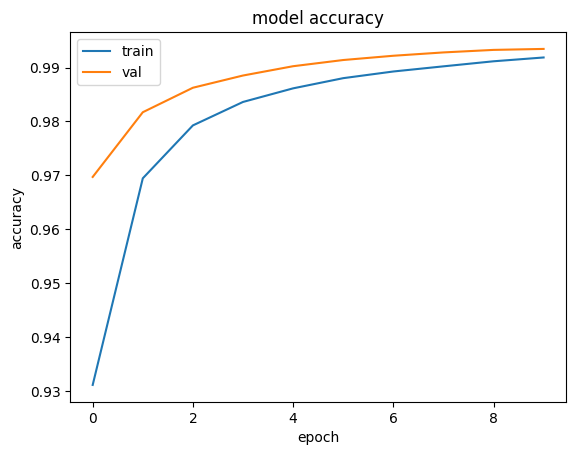

In [23]:
from matplotlib import pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# 8- Predict

In [24]:
def predict(line, model):
    words = []
    if "words" in line:
        words = line['words']
    dic = {"sentence": remove_diacritics_line(line['sentence']), "words": words}
    #line['sentence'] = remove_diacritics_line(line['sentence'])

    X, Y = get_classes([dic])
    
    predictions = model.predict(X, verbose=0).squeeze()
    predictions = predictions[1:-1]

    output = ''
    for char, prediction in zip(remove_diacritics_line(dic['sentence']), predictions):
        output += char
        if char not in list(ARABIC_CHAR):
            continue
        output += reverse_class_mapping[np.argmax(prediction)]
    return output

def predict_text(data, model, file_name):
  for idx, line in enumerate(data):
    output = predict(line, model)

    with open(f"{file_name}_out.txt", 'a', encoding="utf-8") as file:
      file.write(output + "\n")

    with open(f"{file_name}_inp.txt", 'a', encoding="utf-8") as file:
      file.write(line['sentence'] + "\n")

In [25]:
# model_file_path = 'bilstmWSD.joblib'
# model = joblib.load(model_file_path)

In [26]:
test_data = read_json("../Dataset/2528_test_wsd.json")
print('Testing data length:', len(test_data))
print("Test Sample")
pprint(test_data[100])

Testing data length: 2528
Test Sample


{
  "sentence": "قَوْلُهُ لَمْ يَجُزْ لَهُ التَّيَمُّمُ ) يُتَأَمَّلُ وَجْهُ ذَلِكَ .",
  "words": [
    {
      "pos": "noun",
      "sense": "saying",
      "word": "قَوْلُهُ"
    },
    {
      "pos": "verb",
      "sense": "not permitted",
      "word": "لَمْ يَجُزْ"
    },
    {
      "pos": "preposition",
      "sense": "for",
      "word": "لَهُ"
    },
    {
      "pos": "noun",
      "sense": "dry ablution",
      "word": "التَّيَمُّمُ"
    },
    {
      "pos": "verb",
      "sense": "to be contemplated",
      "word": "يُتَأَمَّلُ"
    },
    {
      "pos": "noun",
      "sense": "face",
      "word": "وَجْهُ"
    },
    {
      "pos": "pronoun",
      "sense": "that",
      "word": "ذَلِكَ"
    }
  ]
}

In [27]:
predict_text(test_data, model, "./Outputs/Bilstm_wsd")

# 9- Error Calculation

In [28]:
# -*- coding: utf-8 -*-

import sys
import argparse
import pickle as pkl

def get_diacritic_class(idx, line, case_ending, arabic_letters, diacritic_classes):
  # Handle without case ending
  if not case_ending:
    end = True
    for i in range(idx + 1, len(line)):
      if line[i] not in diacritic_classes:
        end = line[i].isspace()
        break
    if end:
      return -1

  if idx + 1 >= len(line) or line[idx + 1] not in diacritic_classes:
    # No diacritic
    return 0

  diac = line[idx + 1]

  if idx + 2 >= len(line) or line[idx + 2] not in diacritic_classes:
    # Only one diacritic
    return diacritic_classes.index(diac) + 1

  diac += line[idx + 2]

  try:
    # Try the possibility of double diacritics
    return diacritic_classes.index(diac) + 1
  except:
    try:
      # Try the possibility of reversed double diacritics
      return diacritic_classes.index(diac[::-1]) + 1
    except:
      # Otherwise consider only the first diacritic
      return diacritic_classes.index(diac[0]) + 1

def get_diacritics_classes(line, case_ending, arabic_letters, diacritic_classes, style):
  classes = list()
  for idx, char in enumerate(line):
    if style == 'Fadel':
      if char in arabic_letters:
        classes.append(get_diacritic_class(idx, line, case_ending, arabic_letters, diacritic_classes))
    elif style == 'Zitouni':
      if char in diacritic_classes or char.isspace():
        continue
      classes.append(get_diacritic_class(idx, line, case_ending, arabic_letters, diacritic_classes))
  return classes

def clear_line(line, arabic_letters, diacritic_classes):
  line = ' '.join(''.join([char if char in list(arabic_letters) + diacritic_classes + [' '] else ' ' for char in line]).split())
  new_line = ''
  for idx, char in enumerate(line):
  	if char not in diacritic_classes or (idx > 0 and line[idx - 1] != ' '):
  		new_line += char
  line = new_line
  new_line = ''
  for idx, char in enumerate(line):
  	if char not in diacritic_classes or (idx > 0 and line[idx - 1] != ' '):
  		new_line += char
  return new_line

def calculate_der(original_file, target_file, arabic_letters, diacritic_classes, style, case_ending=True, no_diacritic=True):
  with open(original_file, 'r', encoding="utf8") as file:
    original_content = file.readlines()

  with open(target_file, 'r', encoding="utf8") as file:
    target_content = file.readlines()

  assert(len(original_content) == len(target_content))

  equal = 0
  not_equal = 0
  for (original_line, target_line) in zip(original_content, target_content):
    if style == 'Fadel':
      original_line = clear_line(original_line, arabic_letters, diacritic_classes)
      target_line = clear_line(target_line, arabic_letters, diacritic_classes)

    original_classes = get_diacritics_classes(original_line, case_ending, arabic_letters, diacritic_classes, style)
    target_classes = get_diacritics_classes(target_line, case_ending, arabic_letters, diacritic_classes, style)
    if len(original_classes) != len(target_classes):
       continue
    assert(len(original_classes) == len(target_classes))

    for (original_class, target_class) in zip(original_classes, target_classes):
      if not no_diacritic and original_class == 0:
        continue
      if original_class == -1 and target_class != -1:
        print('WOW!')
      if original_class != -1 and target_class == -1:
        print('WOW!')
      if original_class == -1 and target_class == -1:
        continue

      equal += (original_class == target_class)
      not_equal += (original_class != target_class)

  return round(not_equal / max(1, (equal + not_equal)) * 100, 2)

def calculate_wer(original_file, target_file, arabic_letters, diacritic_classes, style, case_ending=True, no_diacritic=True):
  with open(original_file, 'r', encoding="utf8") as file:
    original_content = file.readlines()

  with open(target_file, 'r', encoding="utf8") as file:
    target_content = file.readlines()

  assert(len(original_content) == len(target_content))

  equal = 0
  not_equal = 0
  for idx, (original_line, target_line) in enumerate(zip(original_content, target_content)):
    if style == 'Fadel':
      original_line = clear_line(original_line, arabic_letters, diacritic_classes)
      target_line = clear_line(target_line, arabic_letters, diacritic_classes)

    original_line = original_line.split()
    target_line = target_line.split()
    if len(original_line) != len(target_line):
       continue
    assert(len(original_line) == len(target_line))

    for (original_word, target_word) in zip(original_line, target_line):
      original_classes = get_diacritics_classes(original_word, case_ending, arabic_letters, diacritic_classes, style)
      target_classes = get_diacritics_classes(target_word, case_ending, arabic_letters, diacritic_classes, style)

      if len(original_classes) != len(target_classes):
       continue
      assert(len(original_classes) == len(target_classes))

      if len(original_classes) == 0:
        continue

      equal_classes = 0
      for (original_class, target_class) in zip(original_classes, target_classes):
        if not no_diacritic and original_class == 0:
          equal_classes += 1
          continue
        equal_classes += (original_class == target_class)

      equal += (equal_classes == len(original_classes))
      not_equal += (equal_classes != len(original_classes))

  return round(not_equal / max(1, (equal + not_equal)) * 100, 2)

def calculate_ser(original_file, target_file, arabic_letters, diacritic_classes, style, case_ending=True, no_diacritic=True):
  with open(original_file, 'r', encoding="utf8") as file:
    original_content = file.readlines()

  with open(target_file, 'r', encoding="utf8") as file:
    target_content = file.readlines()

  assert(len(original_content) == len(target_content))

  equal = 0
  not_equal = 0
  for idx, (original_line, target_line) in enumerate(zip(original_content, target_content)):
    if style == 'Fadel':
      original_line = clear_line(original_line, arabic_letters, diacritic_classes)
      target_line = clear_line(target_line, arabic_letters, diacritic_classes)

    original_line = original_line.split()
    target_line = target_line.split()

    assert(len(original_line) == len(target_line))

    equal_words = True
    for (original_word, target_word) in zip(original_line, target_line):
      original_classes = get_diacritics_classes(original_word, case_ending, arabic_letters, diacritic_classes, style)
      target_classes = get_diacritics_classes(target_word, case_ending, arabic_letters, diacritic_classes, style)
      if len(original_classes) != len(target_classes):
          continue
      assert(len(original_classes) == len(target_classes))

      if len(original_classes) == 0:
        continue

      equal_classes = 0
      for (original_class, target_class) in zip(original_classes, target_classes):
        if not no_diacritic and original_class == 0:
          equal_classes += 1
          continue
        equal_classes += (original_class == target_class)

      if equal_classes != len(original_classes):
        equal_words = False

    equal += equal_words
    not_equal += not equal_words

  return round(not_equal / max(1, (equal + not_equal)) * 100, 2)

def cl_der(original_file_path, target_file_path, style='Fadel'):
  print('+---------------------------------------------------------------------------------------------+')
  print('|       |  With case ending  | Without case ending |  With case ending  | Without case ending |')
  print('|  DER  |------------------------------------------+------------------------------------------|')
  print('|       |          Including no diacritic          |          Excluding no diacritic          |')
  print('|-------+------------------------------------------+------------------------------------------|')
  print('|   %%   |        %5.2f       |        %5.2f        |        %5.2f       |        %5.2f        |' %
        (calculate_der(original_file_path, target_file_path, ARABIC_CHAR_SPACE, DIACRITICS, style),
        calculate_der(original_file_path, target_file_path, ARABIC_CHAR_SPACE, DIACRITICS, style, case_ending=False),
        calculate_der(original_file_path, target_file_path, ARABIC_CHAR_SPACE, DIACRITICS, style, no_diacritic=False),
        calculate_der(original_file_path, target_file_path, ARABIC_CHAR_SPACE, DIACRITICS, style, case_ending=False, no_diacritic=False)))
  print('+---------------------------------------------------------------------------------------------+')
  print('')
  print('+---------------------------------------------------------------------------------------------+')
  print('|       |  With case ending  | Without case ending |  With case ending  | Without case ending |')
  print('|  WER  |------------------------------------------+------------------------------------------|')
  print('|       |          Including no diacritic          |          Excluding no diacritic          |')
  print('|-------+------------------------------------------+------------------------------------------|')
  print('|   %%   |        %5.2f       |        %5.2f        |        %5.2f       |        %5.2f        |' %
        (calculate_wer(original_file_path, target_file_path, ARABIC_CHAR_SPACE, DIACRITICS, style),
        calculate_wer(original_file_path, target_file_path, ARABIC_CHAR_SPACE, DIACRITICS, style, case_ending=False),
        calculate_wer(original_file_path, target_file_path, ARABIC_CHAR_SPACE, DIACRITICS, style, no_diacritic=False),
        calculate_wer(original_file_path, target_file_path, ARABIC_CHAR_SPACE, DIACRITICS, style, case_ending=False, no_diacritic=False)))
  print('+---------------------------------------------------------------------------------------------+')

In [30]:
original_path = "./Outputs/Bilstm_wsd_inp.txt"
predicted_path  = "./Outputs/Bilstm_wsd_out.txt"
cl_der(original_path, predicted_path)

+---------------------------------------------------------------------------------------------+
|       |  With case ending  | Without case ending |  With case ending  | Without case ending |
|  DER  |------------------------------------------+------------------------------------------|
|       |          Including no diacritic          |          Excluding no diacritic          |
|-------+------------------------------------------+------------------------------------------|
|   %   |        12.77       |        11.45        |        18.06       |        16.74        |
+---------------------------------------------------------------------------------------------+

+---------------------------------------------------------------------------------------------+
|       |  With case ending  | Without case ending |  With case ending  | Without case ending |
|  WER  |------------------------------------------+------------------------------------------|
|       |          Including no diacrit